In [34]:
import sys
import os
# sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import expm, logm

# from utils import Stiefel_Exp_Log as SEL
# from utils import stiefel as stf
from sklearn.manifold import SpectralEmbedding
import umap
import time
seed = 41

from sklearn.manifold import SpectralEmbedding

plt.rcParams['font.size'] = 15.5
plt.rcParams['axes.labelsize'] = 15.5
plt.rcParams['xtick.labelsize'] = 15.5
plt.rcParams['ytick.labelsize'] = 15.5
plt.rcParams['legend.fontsize'] = 15.5

In [35]:
print(os.getcwd())

/data1/yq87/CRISPS/Na3SbSe4-May62024/SIM_15ps_ALLSS


In [36]:
## Parameters of ROB
Nd = 1016 * 3
numSamples = 1000
trunc_err = '1e-6'

## case gamma == 1e-5
## NrLF_err == 1e-5
gamma = '1e-5'
Nr = 983
NrLF_err = '1e-5'
NrLF = 622
NrHF = 361


# # case gamma == 0
# gamma = '0'
# Nr = 784
# NrLF_err = '1e-5'
# NrLF = 606
# NrHF = 178

In [37]:
potentialLst = ['NEP', 'MLIP']
datafolderpath = f"{os.getcwd()}/fom_data_15ps/robdata_{trunc_err}"
# load ROB
globalFile = f"{datafolderpath}/Global/rob_trunc_{Nr}_{gamma}.txt"
robGlobal = np.loadtxt(globalFile, delimiter=' ')
print("robGlobal shape: ", robGlobal.shape)
robGlobalLF = robGlobal[:, :NrLF]
print("robGlobalLF shape: ", robGlobalLF.shape)
robGlobalHF = robGlobal[:, NrLF:]
print("robGlobalHF shape: ", robGlobalHF.shape)

robGlobal shape:  (3048, 983)
robGlobalLF shape:  (3048, 622)
robGlobalHF shape:  (3048, 361)


In [38]:
# load individual ROBs
robLst = []
robHFLst = []
robLFLst = []

for potential in potentialLst:
    # robFile = "{}/{}/rob.{}_run".format(datafolderpath, potential, potential.lower())
    robFile =f"{datafolderpath}/{potential}/rob_trunc_{Nr}_{gamma}.txt"
    # read the file for all rows
    rob = np.loadtxt(robFile, delimiter=' ', max_rows=Nd)
    # check the number of columns
    if rob.shape[1] < Nr:
        print(f"Warning: The data has only {rob.shape[1]} columns, but you're trying to load {Nr} columns.")
    robLst.append(rob)
    robLF = rob[:, :NrLF]
    robLFLst.append(robLF)
    robHF = rob[:, NrLF:]
    robHFLst.append(robHF)
    print(f"{potential} Nr, NrLF, NrHF: ", rob.shape[1], robLF.shape[1], robHF.shape[1])

print(" ")
print("Appending robGlobal to the list...")
robLst.append(robGlobal)
robHFLst.append(robGlobalHF)
robLFLst.append(robGlobalLF)
print("Number of potentials: ", len(robLst))
print(" ")

NEP Nr, NrLF, NrHF:  983 622 361
MLIP Nr, NrLF, NrHF:  983 622 361
 
Appending robGlobal to the list...
Number of potentials:  3
 


In [39]:
# change this
# robFile = "robSamples.npy"            # robSamples.npy or stiefel_samples_HF.npy
robFile = "stiefel_samples_HF.npy"

In [40]:
if robFile == "robSamples.npy":
    robAnchor = robLst
    savebackLabel = "robSamples"

elif robFile == "stiefel_samples_HF.npy":
    robAnchor = robHFLst
    savebackLabel = "stiefel_samples_HF"
else:
    raise ValueError("robFile must be either robSamples.npy or stiefel_samples_HF.npy")


In [41]:
# randomizationDir = f"{os.getcwd()}/Randomization_eps{trunc_err}_gam{gamma}"
randomizationDir = f"{os.getcwd()}/Rand15ps_eps{trunc_err}/gamma_{gamma}"
dataDir = f"{randomizationDir}/localization/data_LFeps{NrLF_err}_NrLF{NrLF}_NrHF{NrHF}/multi-potential-{numSamples}"

# create a fig dir in dataDir if not
if not os.path.exists(f"{dataDir}/figs"):
    os.makedirs(f"{dataDir}/figs")

stiefel_samples = np.load(f'{dataDir}/{robFile}')
print("stiefel_samples shape: ", stiefel_samples.shape)

maxI = np.load(f'{dataDir}/maxI.npy')
print("maxI shape: ", maxI.shape)

beta = np.load(f'{dataDir}/beta.npy')
print("beta: ", beta)
# round to 4 decimal places
beta = np.round(beta, 4)
print("beta: ", beta)

frechet_mean = np.load(f'{dataDir}/frechet_mean_{savebackLabel}.npy')
print("frechet_mean shape: ", frechet_mean.shape)

print("Shape of a robAnchor element: ", robAnchor[0].shape)

stiefel_samples shape:  (1000, 3048, 361)
maxI shape:  (1000,)
beta:  [0.49937807 0.50062193]
beta:  [0.4994 0.5006]
frechet_mean shape:  (3048, 361)
Shape of a robAnchor element:  (3048, 361)


In [42]:
# plot spectral embedding of the generated stiefel sampels
flat_frechet_mean = frechet_mean.flatten()[:, None]
print('flat_frechet_mean:', flat_frechet_mean.shape)

flat_rob_arr = np.concatenate([rob.flatten()[:, None] for rob in robAnchor], axis=1)
print('flat_rob_arr:', flat_rob_arr.shape)


rob_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples] + [flat_rob_arr] + [flat_frechet_mean], axis=1)
# rob_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples] + [flat_rob_arr], axis=1)
print('rob_all:', rob_all.shape)

# colors = plt.cm.tab20c(np.linspace(0, 1, len(robLst) - 1))
# # colors = plt.cm.tab10(np.linspace(0, 1, len(robLst) - 1))
# # colors = plt.cm.Set1.colors

flat_frechet_mean: (1100328, 1)
flat_rob_arr: (1100328, 3)
rob_all: (1100328, 1004)


In [43]:
# colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
# colors = plt.cm.tab10(np.linspace(0, 1, len(robLst) - 1))
# colors = plt.cm.Set1.colors

# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2, random_state= seed)
embedding_Stf = embedder.fit_transform(rob_all.T)
print('embedding_Stf:', embedding_Stf.shape)
print("numSamples: ", numSamples)

embedding_Stf: (1004, 2)
numSamples:  1000


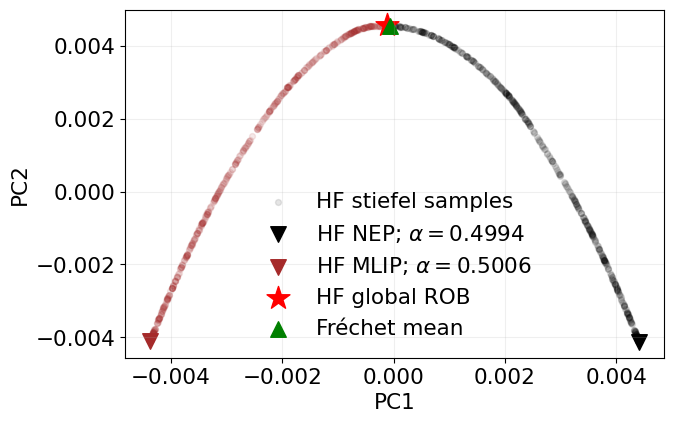

In [44]:
colors = ['k', 'brown']
fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(111)

# Add a dummy scatter plot for the legend entry
ax.scatter([], [], color='gray', marker='o', label='HF stiefel samples', alpha=0.2, s=18)

# plot the samples 
for i in range(numSamples):
    ax.scatter(embedding_Stf[i, 0], embedding_Stf[i, 1], color=colors[maxI[i]], alpha=0.1, s=18)

for i in range(len(robLst)-1):
    ax.scatter(embedding_Stf[numSamples+i, 0], embedding_Stf[numSamples+i, 1], color=colors[i],
                label=rf'HF {potentialLst[i]}; $\alpha=${beta[i]:.4f}', alpha=1, marker='v', s=125)


# ax.scatter(embedding_Stf[-1, 0], embedding_Stf[-1, 1], color='red', marker="*", label='global ROB', s=300, alpha=1)
    
## for when there is frechet mean 
ax.scatter(embedding_Stf[-2, 0], embedding_Stf[-2, 1], color='red', marker="*", label='HF global ROB', s=300, alpha=1)
ax.scatter(embedding_Stf[-1, 0], embedding_Stf[-1, 1], color='green', marker="^", label='Fréchet mean', s=125, alpha=1)
############################################

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.grid(True, alpha=0.2)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"{dataDir}/figs/spectral_embedding_{savebackLabel}_LFeps{NrLF_err}_NrLF{NrLF}_NrHF{NrHF}_colored.png")

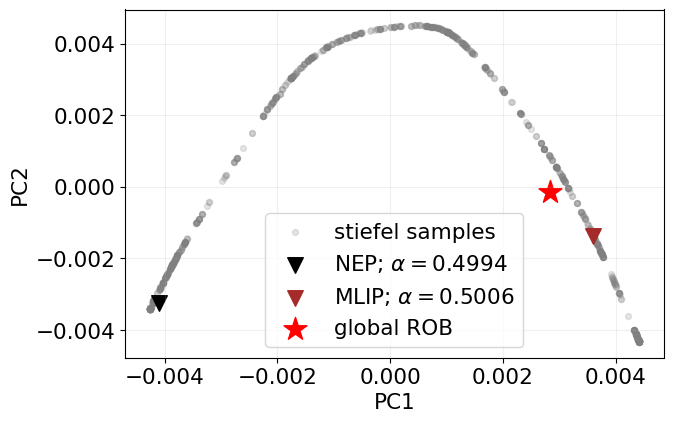

In [51]:
colors = ['k', 'brown']
fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(111)

# plot the gray samples
ax.scatter(embedding_Stf[:, 0], embedding_Stf[:, 1], color='gray', label='stiefel samples', alpha=0.2, s=18)

for i in range(len(robLst)-1):
    ax.scatter(embedding_Stf[numSamples+i, 0], embedding_Stf[numSamples+i, 1], color=colors[i],
                label=rf'{potentialLst[i]}; $\alpha=${beta[i]:.4f}', alpha=1, marker='v', s=125)


ax.scatter(embedding_Stf[-1, 0], embedding_Stf[-1, 1], color='red', marker="*", label='global ROB', s=300, alpha=1)
    
# ## for when there is frechet mean 
# ax.scatter(embedding_Stf[-2, 0], embedding_Stf[-2, 1], color='red', marker="*", label='HF global ROB', s=300, alpha=1)
# ax.scatter(embedding_Stf[-1, 0], embedding_Stf[-1, 1], color='green', marker="^", label='Fréchet mean', s=125, alpha=1)
# ############################################

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.grid(True, alpha=0.2)
ax.legend()
plt.tight_layout()
plt.savefig(f"{dataDir}/figs/spectral_embedding_{savebackLabel}_LFeps{NrLF_err}_NrLF{NrLF}_NrHF{NrHF}.png")

In [52]:
# # plot the spectral embedding
# fig = plt.figure(figsize=(7, 6))
# ax = fig.add_subplot(111)
# # ax.scatter(embedding_Stf[:numSamples, 0], embedding_Stf[:numSamples, 1], color='gray', label='Stiefel Samples', alpha=0.4, s=20)
# # plot the stiefel samples according to their maxI
# for i in range(numSamples):
#     ax.scatter(embedding_Stf[i, 0], embedding_Stf[i, 1], color=colors[maxI[i]], alpha=0.4, s=20)
# for i in range(len(robLst)-1):
#     ax.scatter(embedding_Stf[numSamples+i, 0], embedding_Stf[numSamples+i, 1], color=colors[i], label=f'ROB; alpha={beta[i]:.3f}', alpha=1, marker='v', s=80, edgecolors='gray')
#     # ax.text(embedding_Stf[numSamples+i, 0], embedding_Stf[numSamples+i, 1], f'alpha={beta.value[i]:.3f}', fontsize=7)
# # ax.scatter(embedding_Stf[-1, 0], embedding_Stf[-1, 1], color='green', marker="*", label='Frechet Mean', s=100, alpha=1)
# ax.scatter(embedding_Stf[-2, 0], embedding_Stf[-2, 1], color='red', marker="*", label='Nominal ROB', s=100, alpha=1)
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_title('Spectral Embedding of Stiefel Samples')
# ax.legend()
# plt.tight_layout()
# # save fig
# plt.savefig('../figs/spectral_embedding_stiefel_samples.png')

## UMAP

In [53]:
# embedder_UMAP = umap.UMAP(n_components=2, random_state=seed)
# embedding_UMAP = embedder_UMAP.fit_transform(rob_all.T)
# print('embedding_UMAP:', embedding_UMAP.shape)
# print("numSamples: ", numSamples)

In [54]:
# colors = ['k', 'brown']
# fig = plt.figure(figsize=(7, 4.5))
# ax = fig.add_subplot(111)
# # ax.scatter(embedding_UMAP[:numSamples, 0], embedding_UMAP[:numSamples, 1], color='gray', label='Stiefel Samples', alpha=0.4, s=20)
# # plot the stiefel samples according to their maxI
# for i in range(numSamples):
#     # ax.scatter(embedding_UMAP[i, 0], embedding_UMAP[i, 1], color=colors[maxI[i]], alpha=0.4, s=20)
#     ax.scatter(embedding_UMAP[i, 0], embedding_UMAP[i, 1], color='gray', label='stiefel samples', alpha=0.4, s=15)

# for i in range(len(robLst)-1):
#     ax.scatter(embedding_UMAP[numSamples+i, 0], embedding_UMAP[numSamples+i, 1], color=colors[i], 
#                label=rf'{potentialLst[i]}; $\alpha=${beta[i]:.4f}', alpha=1, marker='v', s=80)
#     # ax.text(embedding_UMAP[numSamples+i, 0], embedding_UMAP[numSamples+i, 1], f'alpha={beta.value[i]:.3f}', fontsize=7)
# # ax.scatter(embedding_UMAP[-1, 0], embedding_UMAP[-1, 1], color='green', marker="*", label='Frechet Mean', s=100, alpha=1)
# ax.scatter(embedding_UMAP[-1, 0], embedding_UMAP[-1, 1], color='red', marker="*", label='global ROB', s=140, alpha=1)
# ax.set_xlabel('UMAP1')
# ax.set_ylabel('UMAP2')
# ax.grid(True, alpha=0.2)
# ax.legend()
# plt.tight_layout()
# # save fig
# plt.savefig(f'{dataDir}/figs/UMAP_{savebackLabel}_LFeps{NrLF_err}_NrLF{NrLF}_NrHF{NrHF}.png')